## Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

 

## Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

 

## Dataset:

The dataset has the following columns:

- tweet_id                                                           
- airline_sentiment                                               
- airline_sentiment_confidence                               
- negativereason                                                   
- negativereason_confidence                                    
- airline                                                                    
- airline_sentiment_gold                                              
- name     
- negativereason_gold 
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location 
- user_timezone


## Objective :
- Explore and visualize the dataset.
- Text preprocessing
- **build a model for text-classification**.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Import the libraries

In [2]:
# install and import necessary libraries.

#!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import matplotlib.pyplot as plt                         # Import plt for visualization
%matplotlib inline
import seaborn as sns                                   # Used for plotting
import nltk                                             # Import Natural Language Tool-Kit.

#nltk.download('stopwords')                              # Download Stopwords.
#nltk.download('punkt')
#nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from collections import Counter                         # count the key-value pairs in an object
import wordcloud
# Used for plotting the wordcloud of a corpus
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings

warnings.filterwarnings("ignore")

## load dataset

In [3]:
data=pd.read_csv('drive/My Drive/Colab Notebooks/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## print the shape of data

In [4]:
data.shape

(14640, 15)

## Data description

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- `tweet_id`, `airline_sentiment_confidence`, `negativereason_confidence`, `retweet_count` are numerical.
- There are missing values in some columns.

In [6]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

- The two main columns for the classification `airline_sentiment`, `text` have no missing values.

In [7]:
# view the statistical summary of all the columns in the data
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,NaN,NaN,NaN,569218351767382528.0,779111158481836.75,567588278875213824.0,568559178101439488.0,569477857923110912.0,569890473289000960.0,570310600460525568.0
airline_sentiment,14640,3,negative,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,14640.0,NaN,NaN,NaN,0.900169,0.16283,0.335,0.6923,1.0,1.0,1.0
negativereason,9178,10,Customer Service Issue,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,10522.0,NaN,NaN,NaN,0.638298,0.33044,0.0,0.3606,0.6706,1.0,1.0
airline,14640,6,United,3822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,40,3,negative,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,14640,7701,JetBlueNews,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_gold,32,13,Customer Service Issue,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,14640.0,NaN,NaN,NaN,0.08265,0.745778,0.0,0.0,0.0,0.0,44.0


- The Dataset have 14640 tweets for 6 Airlines.
- There are 10 negative reasons, the top of is the customer service isues with ferquence 2910.
- 13 unique values for negativereason_gold and the top reason is the customer service issue.
- There are 3 unique values for the airline sentiment and `negative` is the top sentiment with frequency 9178.
- `JetBlueNews` is the Top Name with 63 tweets.
- 75% of the tweets have confidece 1.0

# Exploratory data analysis


In [8]:
 # function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

a. Plot the distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets. 

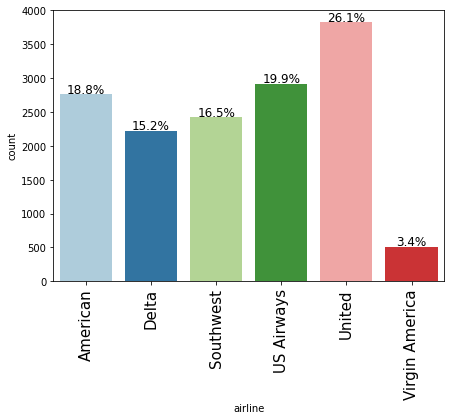

In [9]:
labeled_barplot(data, 'airline', perc=True)

- 26% of the tweets are for `United` airline.
- 19.9% f the tweets are for `US Airways`.
- while 3.4% are for `Virgin America`.

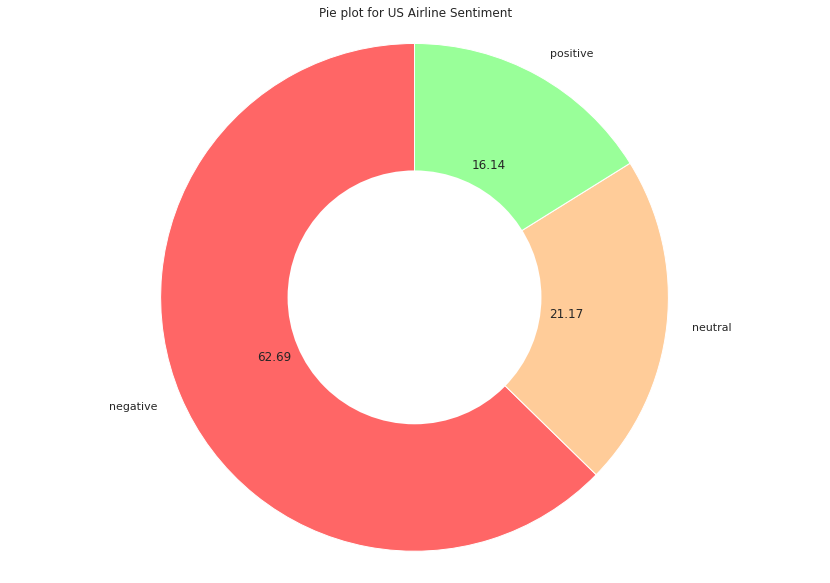

In [10]:
#plot the distribution of sentiment across all the tweets.

colors = ['#ff6666', '#ffcc99', '#99ff99']

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = plt.pie(data['airline_sentiment'].value_counts(), labels=data['airline_sentiment'].value_counts().index, colors=colors, startangle=90,  autopct='%.2f')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pie plot for US Airline Sentiment')
plt.axis('equal')
plt.tight_layout()
plt.show()

- Almost 63% of the tweets are negative sentiment. 
- while 16% are positive

b. Plot the distribution of Sentiment of tweets for each airline & plot the distribution of all the negative reasons.

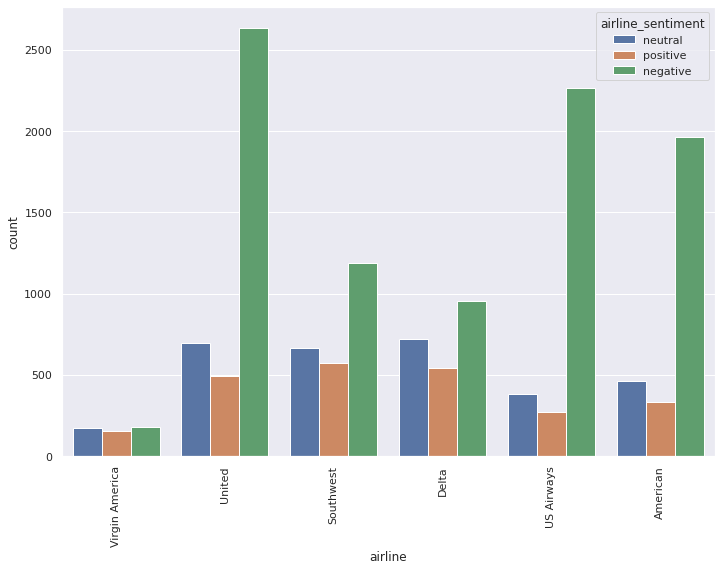

In [11]:
sns.countplot(data = data, x ="airline", hue = "airline_sentiment");
plt.xticks(rotation =90);

- `United`, `US Airways`, and `American` have most of the negative tweets and also have more numbers of tweets than the other airlines.
- `Virgin America`, `Southwest`, and `Delta` have less tweets with almost balanced sentiment values.

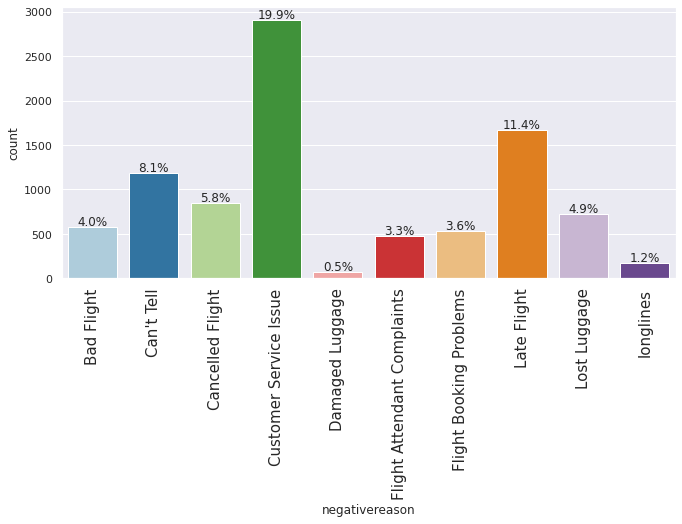

In [12]:
labeled_barplot(data, 'negativereason', perc=True)

- 20% of the negative reasons are for the customer service issues.
- while 11.4% are for late flights and 5.8% for cancelled flights.

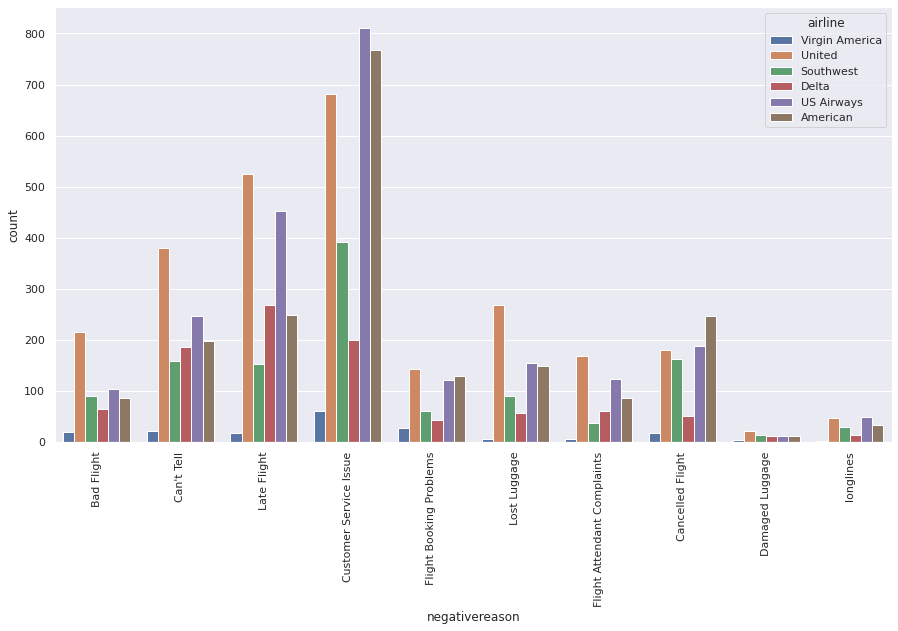

In [13]:
plt.figure(figsize=(15,8))
ax =sns.countplot(data = data, x ="negativereason", hue = "airline");
plt.xticks(rotation =90);

- `United` airline has the highest count of most of the negative reasons. 
- `US Airways` and `American` have the highest count for the Customer Service Issue.
- `Damaged Luggage` is the least count as negative reason among the airlines.
- `Virgin America` airline has the least count of tweets and the least count among all the negative reasons.

 c. Plot the word cloud graph of tweets for positive and negative sentiment separately. Mention the observations & insights after plotting each graph.

In [14]:
# split the dataset into 2 dataframes for positive and negative sentiment
Positive_sent = data[data['airline_sentiment']=='positive']
Negative_sent = data[data['airline_sentiment']=='negative']


In [15]:
def show_wordcloud(sentiment, title):
    text = ' '.join(sentiment['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

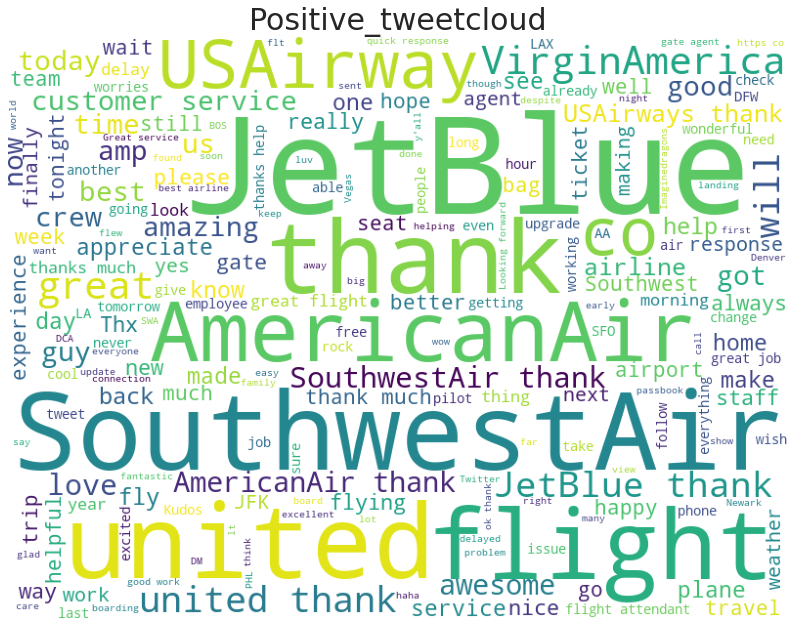

In [16]:
show_wordcloud(Positive_sent, "Positive_tweetcloud")

- The highest mentiond airlines in the tweets 'united', 'USAirway', 'American', 'Southwest'.
- Name 'JetBlue' has alot of positive tweets.
- words like `thank`, `flight`,`great`, `awesome`, `love`, `best` present with high frequency in positive sentiments

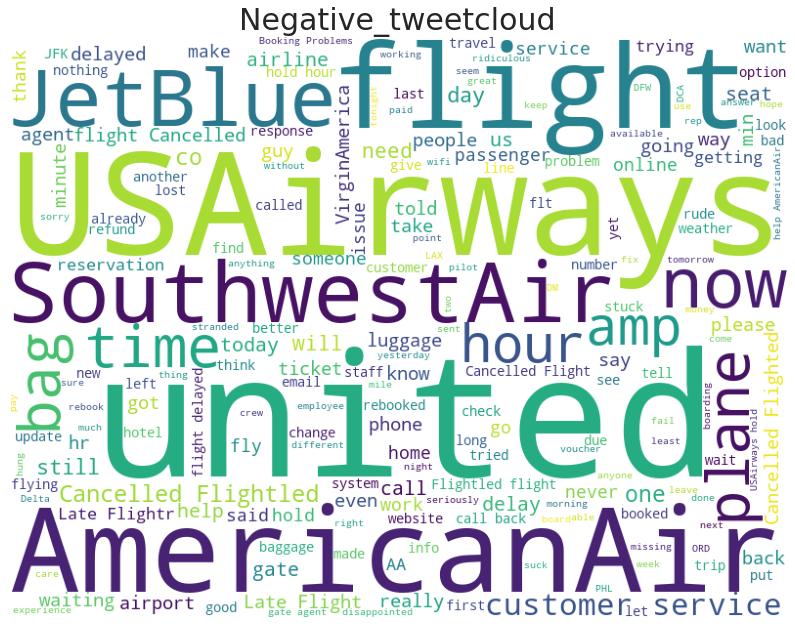

In [17]:
show_wordcloud(Negative_sent, "Negative_tweetcloud")

- words like `flight`, `time`,`plane`, `bag`, `Customr Servive`, `flight Cancelled` present with high frequency in the negative sentiment.

## Understanding of Data Columns
a. Drop all other columns except “text” and “airline_sentiment”. 

In [18]:
tweets = data.loc[:,['text','airline_sentiment']]

b. Check the shape of the data. 

In [19]:
tweets.shape

(14640, 2)

c. Print the first 5 rows of data.

In [20]:
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## Data Pre - Processing
 Text pre-processing: Data preparation. 

a. Html tag removal.  

In [21]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

tweets['text'] = tweets['text'].apply(lambda x: strip_html(x))


- Remove the URL's.

In [22]:
# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

tweets['text'] = tweets['text'].apply(lambda x: remove_url(x))
tweets.tail()

,text,airline_sentiment
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative
14639,@AmericanAir we have 8 ppl so we need 2 know h...,neutral


b. Remove the numbers. 

In [23]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweets['text'] = tweets['text'].apply(lambda x: remove_numbers(x))
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


c. Tokenization.

In [24]:
tweets['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
tweets.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, 've, added, comm...",positive
2,"[@, VirginAmerica, I, did, n't, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, 's, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, 's, a, really, big...",negative


d. Removal of Special Characters and Punctuations. 

In [25]:
def remove_special_Characters(words):
    """Remove special Characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^a-zA-Z0-9]', '', word) # using regular expression to remove special characters
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_special_Characters(x))
tweets.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, ve, added, commerci...",positive
2,"[VirginAmerica, I, did, nt, today, Must, mean,...",neutral
3,"[VirginAmerica, it, s, really, aggressive, to,...",negative
4,"[VirginAmerica, and, it, s, a, really, big, ba...",negative


In [26]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_punctuation(x))
tweets.head()


,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, ve, added, commerci...",positive
2,"[VirginAmerica, I, did, nt, today, Must, mean,...",neutral
3,"[VirginAmerica, it, s, really, aggressive, to,...",negative
4,"[VirginAmerica, and, it, s, a, really, big, ba...",negative


e. Conversion to lowercase. 

In [27]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: to_lowercase(x))
tweets.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, you, ve, added, commerci...",positive
2,"[virginamerica, i, did, nt, today, must, mean,...",neutral
3,"[virginamerica, it, s, really, aggressive, to,...",negative
4,"[virginamerica, and, it, s, a, really, big, ba...",negative


f. Removal of stopwords 

In [28]:
stopwords = stopwords.words('english')

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_stopwords(x))
tweets.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercials, expe...",positive
2,"[virginamerica, nt, today, must, mean, need, t...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


g. Lemmatize or stemming. 

In [29]:
lemmatizer = WordNetLemmatizer()

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: lemmatize_list(x))
tweets.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercial, exper...",positive
2,"[virginamerica, nt, today, must, mean, need, t...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


h. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)

In [30]:
def join_text(words):
    return ' '.join(words)

tweets['text']=tweets.apply(lambda x: join_text(x['text']), axis=1)

i. Print the first 5 rows of data after pre-processing

In [31]:
tweets.head()

,text,airline_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plus added commercial experience...,positive
2,virginamerica nt today must mean need take ano...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


## CountVectorizer

In [32]:
# Vectorization (Convert text data to numbers).

bow_vec = CountVectorizer(max_features=500)                # Keep only 500 features as number of features will increase the processing time.
data_features = bow_vec.fit_transform(tweets['text'])

data_features = data_features.toarray()                        # Convert the data features to array.
data_features.shape

(14640, 500)

### Modelling , tuning and Evaluation
- Fit the model using vectorized column 

In [33]:
X = data_features
y = tweets.airline_sentiment

# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7759562841530054

- Tune the model to improve the accuracy 

In [35]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [36]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

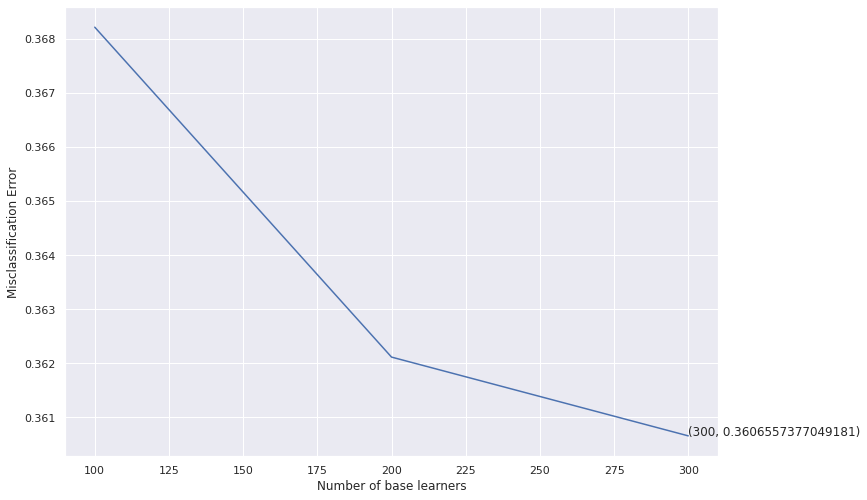

In [37]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [38]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7734972677595628

- Evaluate the model using the confusion matrix
- Target the final score >= 75% 

In [39]:
from sklearn.metrics import accuracy_score

count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      2627
     neutral       0.47      0.34      0.40       577
    positive       0.61      0.65      0.63       456

    accuracy                           0.77      3660
   macro avg       0.64      0.63      0.63      3660
weighted avg       0.76      0.77      0.76      3660

Accuracy of the model is :  0.7734972677595628


[[2334  181  112]
 [ 301  199   77]
 [ 118   40  298]]


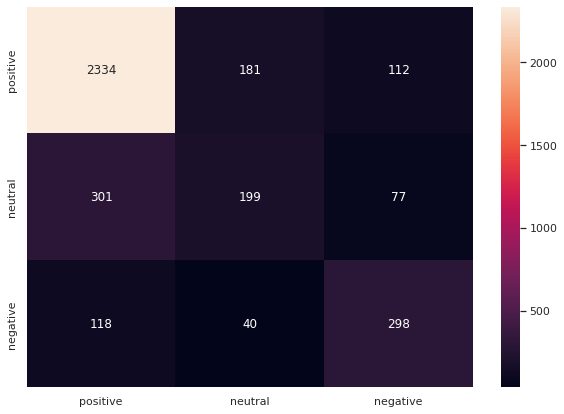

In [40]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive','neutral', 'negative']],
                  columns = [i for i in ['positive','neutral', 'negative']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The model performed well in case of Positive and negative sentiment.

- Print the top 40 features and plot their word cloud.

thank,thanks,nt,hour,usairways,united,http,great,jetblue,flight,southwestair,delayed,love,awesome,bag,customer,cancelled,hold,get,airline,amazing,time,virginamerica,best,please,delay,would,good,plane,service,help,one,need,amp,got,guy,know,dm,like,still,
 
 


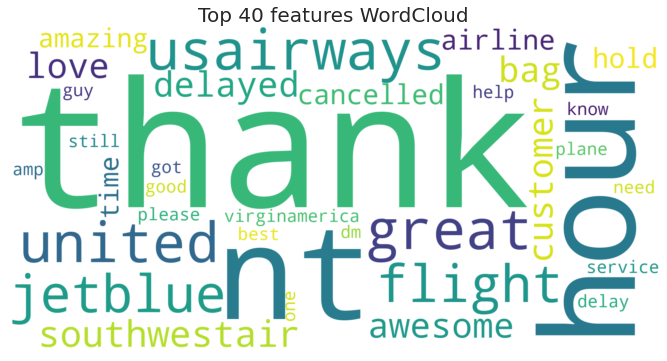

In [41]:
all_features = bow_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

## Term Frequency(TF) - Inverse Document Frequency(IDF)
It makes sure that less importance is given to the most frequent words, and it also considers less frequent words.

In [42]:
# Using TfidfVectorizer to convert text data to numbers.

tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(tweets['text'])

data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 500)

### Modelling , tuning and Evaluation
- Fit the model using vectorized column 

In [43]:
X = data_features
y = tweets.airline_sentiment

# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [44]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7683060109289618

- Tune the model to improve the accuracy 

In [45]:
# K-Fold Cross - validation .
cv_scores = []
# using the optimal numbers of base learner
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

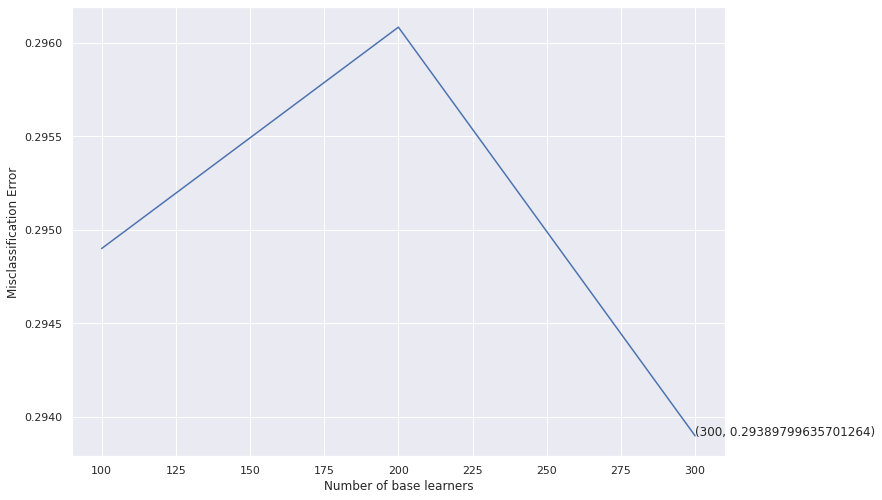

In [46]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [47]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7860655737704918

- Evaluate the model using the confusion matrix 
- Target the final score >= 75% 

In [48]:
from sklearn.metrics import accuracy_score

tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test ,tf_idf_predicted))
print("Accuracy of the model is : ",accuracy_score(y_test, tf_idf_predicted))

              precision    recall  f1-score   support

    negative       0.81      0.95      0.87      2627
     neutral       0.58      0.22      0.32       577
    positive       0.70      0.59      0.64       456

    accuracy                           0.79      3660
   macro avg       0.69      0.58      0.61      3660
weighted avg       0.76      0.79      0.76      3660

Accuracy of the model is :  0.7860655737704918


[[2334  181  112]
 [ 301  199   77]
 [ 118   40  298]]


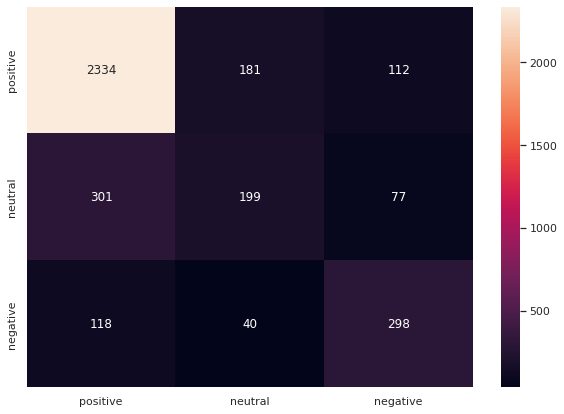

In [49]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive','neutral', 'negative']],
                  columns = [i for i in ['positive','neutral', 'negative']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

- Print the top 40 features and plot their word cloud.

thanks,thank,jetblue,united,southwestair,http,usairways,flight,great,nt,hour,virginamerica,love,awesome,delayed,get,customer,bag,cancelled,please,dm,amazing,best,hold,good,time,airline,help,need,delay,service,would,plane,know,tomorrow,got,fly,guy,like,one,
 
 


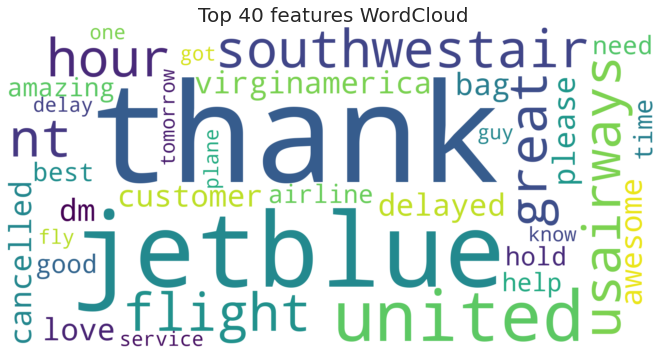

In [50]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

- comparing the accuracies of the models

In [51]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,negative,negative,negative
1,negative,negative,negative
2,negative,negative,negative
3,negative,negative,negative
4,positive,negative,negative


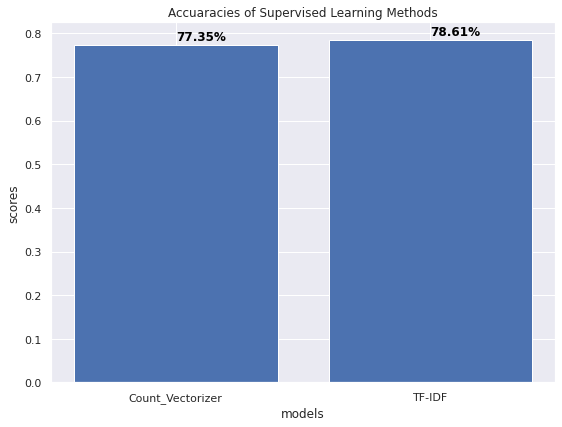

In [52]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

## Conclusion

- The Dataset has **tweets in text format and their sentiment.**
- only **16%** of the tweets are positive sentiment.
- 20% of the negative reasons are for the **customer service issues**.
- **pre-processed the data** using various techniques and libraries.
- The **pre-processed data is converted to numbers (vectorized)**, so that we can feed the data into the model.
- Trained the **Random Forest classifier model** and optimized the parameter.
- **predicted the results for the test data** after building the classification model.
- The models performed well in perspective of how text classification models perform.
- The **TF-IDF vectorized Model have accuracy 78%** and performed slightly higher than the Count victorized Model.
- However, **we can still increase the accuracy of our model by increasing the max_feature parameter** in the vectorizer 
- We can apply **other model tuning and hyperparameter tuning techniques, as well as other pre-processing techniques** to increase the overall accuracy even further.